In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from eyepy.core.base import Oct

In [2]:
def vol_files(name):
    # print(name)
    vol_filename = os.path.join('../OCT_DATASET/dataset/OCT3', name + '.vol')
    oct_read = Oct.from_heyex_vol(vol_filename)
    return oct_read

def get_annotations(oct_read):
    # Outer Plexiform Layer: OPL
    OPL = np.round(
        oct_read.bscans[0].annotation["layers"]['OPL']).astype('uint16')
    INL = np.round(
        oct_read.bscans[0].annotation["layers"]['INL']).astype('uint16')
    # Ellipsoide Zone: EZ
    PR2 = np.round(
        oct_read.bscans[0].annotation["layers"]['PR2']).astype('uint16')
    PR1 = np.round(
        oct_read.bscans[0].annotation["layers"]['PR1']).astype('uint16')
    # BM
    try:
        BM = np.round(
            oct_read.bscans[0].annotation["layers"]['BM']).astype('uint16')
    except:
        BM = np.zeros((PR1.shape[0])).astype('uint16')
        pass
    # ELM
    try:
        ELM = np.round(
            oct_read.bscans[0].annotation["layers"]['ELM']).astype('uint16')
    except:
        ELM = np.zeros((PR1.shape[0])).astype('uint16')
        pass
    return OPL, INL, PR2, PR1, BM, ELM


def crop_overlap(file, img, msk):
    oct_read = vol_files(file)
    OPL, INL, PR2, PR1, BM, ELM = get_annotations(oct_read)
    j = 1
    k = 0

    image = np.array(Image.open(img))
    mask = np.array(Image.open(msk))
    size = 25
    shift = 64
    for i in range(image.shape[1]//2, image.shape[1], 15):
        min_pixel = np.max(PR1[k:i])
        max_pixel = np.max(PR2[k:i])
        if min_pixel != 0 and max_pixel != 0 and max_pixel > min_pixel:
            delta1 = min_pixel - 25 if min_pixel - 25 > 0 else 0
            delta2 = max_pixel + 25 if max_pixel + 25 < 496 else 496
            img_save = image[delta1:delta2, i - size:i]
            msk_save = mask[delta1:delta2, i - size:i] / np.max(mask) * 255.
            img1 = Image.fromarray(img_save).convert('L')
            # img1.save("testI.bmp")
            msk1 = Image.fromarray(msk_save).convert('L')
            #msk1.save("testM.bmp")
            break
            j += 1
        k = i
    return img_save
    
def get_filenames(path, ext):
    X0 = []
    for i in sorted(os.listdir(path)):
        if i.endswith(ext):
            X0.append(os.path.join(path, i))
    return X0

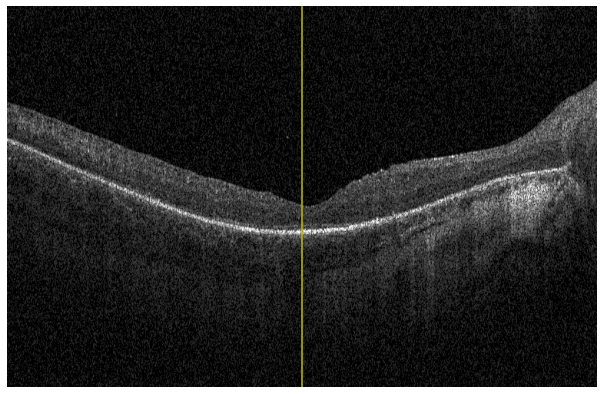

IRD_RPE65_04_I_433_0


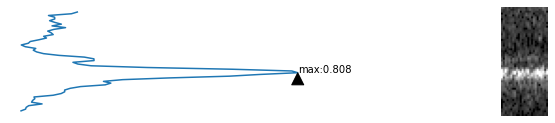

In [3]:
pathI = '../dataset/224_3C/Images_val_large'
pathM = '../dataset/224_3C/Masks_val_large'
filenamesI = get_filenames(pathI, 'tiff')
filenamesM = get_filenames(pathM, 'tiff')
# filenamesI = 'dataset/224_3C/Images_val_large/Anonym_3_1933.tiff'
# filenamesM = 'dataset/224_3C/Masks_val_large/Anonym_3_1933.tiff'


pick = np.random.randint(0, len(filenamesI))
filename = os.path.split(os.path.splitext(filenamesI[pick])[0])[1]
image_orig = Image.open(filenamesI[pick])
plt.figure(figsize=(12, 7))
x1, y1 = [np.array(image_orig).shape[1]//2, np.array(image_orig).shape[1]//2], [0, 496]
plt.plot(x1, y1, 'y-')
plt.imshow(np.array(image_orig), cmap='gray')
plt.axis('off')
plt.show()
# filename = os.path.split(os.path.splitext(filenamesI)[0])[1]
print(filename)
img_crop = crop_overlap(filename, filenamesI[pick], filenamesM[pick])
# img_crop = crop_overlap(filename, filenamesI, filenamesM)
image = 'testI.bmp'
img = img_crop / 255.

x = []
for i in range(img.shape[0]):
    x.append(img[i, :].mean())

y = np.arange(img.shape[0])

xmax = max(x)
ypos = x.index(xmax)
ymax = -y[ypos]

intensity = np.array(x)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(2)
fig.set_figwidth(12)
ax[1].imshow(img, cmap='gray')
ax[0].plot(intensity, -y)

ax[0].annotate(f'max:{xmax:0.3f}', xy=(xmax, ymax), arrowprops=dict(facecolor='black', shrink=0.05))
ax[0].axis('off')
ax[1].axis('off')
plt.show()

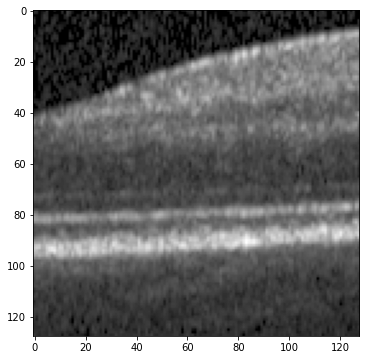

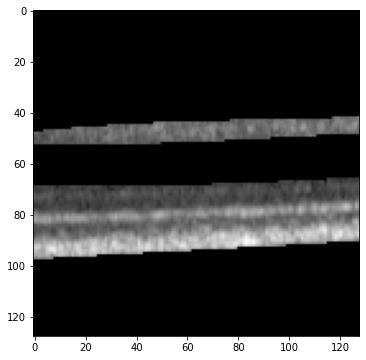

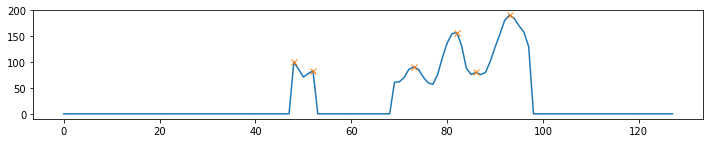

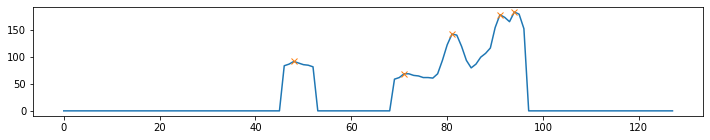

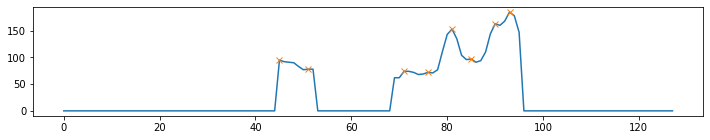

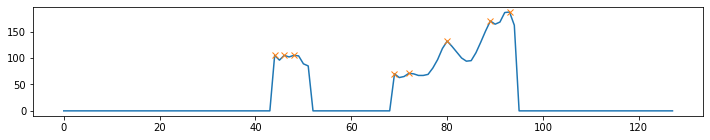

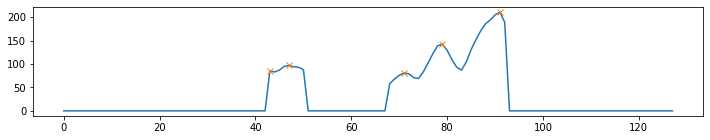

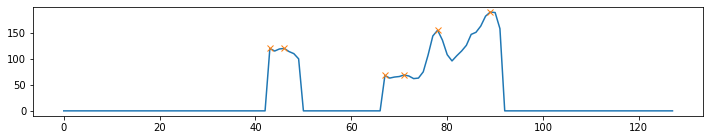

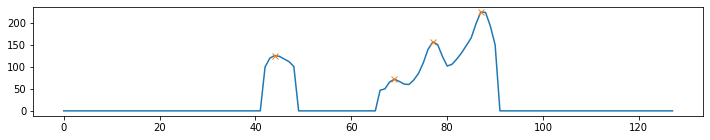

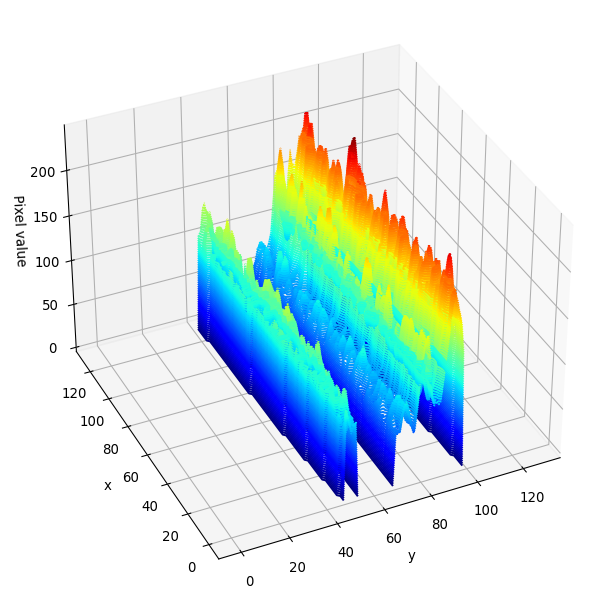

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def get_filenames(path, ext):
    X0 = []
    for i in sorted(os.listdir(path)):
        if i.endswith(ext):
            X0.append(os.path.join(path, i))
    return X0
    
fileImages = get_filenames('../OCT_DATASET/dataset/PatientIDs128_OPL2ELM2BM/val/Images/images_patches', 'npy')
fileMasks = get_filenames('../OCT_DATASET/dataset/PatientIDs128_OPL2ELM2BM/val/Masks/masks_patches', 'npy')

pick = 1
# img = Image.open('dataset/128_3C_May/Images/' + filename)
# msk = Image.open('dataset/128_3C_May/Masks/' + filename)
img = np.load(fileImages[pick])
msk = np.load(fileMasks[pick])
msk = (np.array(msk))


mul = img
mul = np.multiply(img, msk).astype('float')
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
# plt.axis('off')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(mul, cmap='gray')
# plt.axis('off')
plt.show()

def get_max1_max2(img):
    max1 = []
    max2 = []
    int_prof_x = []
    size = 1
    k = 0
    for i in range(size, img.shape[1], size):
        indices = (-img[:, i - size:i].reshape(-1)).argsort()[:2]
        row1 = (int)(indices[0] / size)
        row2 = (int)(indices[1] / size)
        col1 = indices[0] -(row1 * size)
        col2 = indices[1] -(row2 * size)
        temp1 = row1, col1 + k
        temp2 = row2, col2 + k
        k += size
        max1.append(temp1)
        max2.append(temp2)
        window = img[:, i - size:i]
        matrix_mean = np.zeros((img.shape[0]))
        for j in range(window.shape[0]):
            matrix_mean[j] = window[j, :].mean()
        int_prof_x.append(matrix_mean)
    
    for t in range(0, np.array(int_prof_x).shape[0], 20):
        intensity = np.array(int_prof_x)[t, :]
        peaks, _ = find_peaks(intensity, height=0)
        y = np.arange(img.shape[0])
        fig, ax = plt.subplots(nrows=1, ncols=1)
        fig.set_figheight(2)
        fig.set_figwidth(12)
        ax.plot(y, intensity)
        ax.plot(peaks, intensity[peaks], "x")

    Z_INT = np.array(int_prof_x)
    x_int = np.arange(Z_INT.shape[1])
    y_int = np.arange(Z_INT.shape[0])
    X_INT, Y_INT = np.meshgrid(x_int, y_int)
    fig = plt.figure(figsize=(12,8), dpi=96)
    ax = plt.axes(projection='3d')
    ax.contour3D(X_INT, Y_INT, Z_INT, 100, cmap='jet')
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    ax.set_zlabel('Pixel value');
    ax.view_init(35, -115)
    max1 = np.array(max1)
    max2 = np.array(max2)
    x1 = max1[:, 1]
    y1 = max1[:, 0]
    x2 = max2[:, 1]
    y2 = max2[:, 0]


    return x1, x2, y1, y2



x1, x2, y1, y2,  = get_max1_max2(mul)
